In [93]:
import networkx as nx
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def permute_edge_weights(G):
    # Get the edge weights for each edge in the graph
    weights = nx.get_edge_attributes(G, 'weight')
    weights_shuffled = list(weights.values())
    random.shuffle(weights_shuffled)
    weights_shuffled = dict(zip(weights, weights_shuffled))
    return weights_shuffled


In [188]:

directory = '/Users/davorcuric/PhD/postdoc/events_based_network/'

# Create an empty dictionary to store the graphs
graphs = {}

# Loop over the files in the directory
for filename in os.listdir(directory):
    # Check if the file has the correct extension
    if filename.endswith('.gexf'):
        # Load the graph from the file
        graph = nx.read_gexf(os.path.join(directory, filename))
        
        # Add the graph to the dictionary with the filename as the key
        graphs[filename.strip('.gexf')] = graph


# Create a list of all the keys in the graphs dictionary
keys = list(graphs.keys())
# Create a Pandas DataFrame with one column 'keys' and populate it with the keys from the graphs dictionary
df = pd.DataFrame({'keys': keys, 'case': [c[0:-1] for c in keys], 'hemi': [c[-1] for c in keys]})
df = df.sort_values('keys')

#get rid of self loops
for key in df['keys']:
    G = graphs[key]
    G.remove_edges_from(nx.selfloop_edges(G))
    graphs[key] = G

#get rid of the 'left' 'right' node labels
for key in df['keys']:
    graphs[key] = nx.relabel_nodes(graphs[key], {node: node.split(' ')[0] for node in graphs[key].nodes()})

#get the strongly connected components for each graph, make a new dictionary
G_strong = {}
for key in df['keys']:
    nodes = max(nx.strongly_connected_components(graphs[key]), key=len)
    G_strong[key] = graphs[key].subgraph(nodes).copy()

# Find the subgraphs that only contains the common nodes in each graph
inter = set.intersection(*[set(G.nodes()) for G in G_strong.values()])
for key in df['keys']:
    G_strong[key] = nx.subgraph(G_strong[key], inter)
   

In [111]:
#MAke sure each network has the same nodes
# Create a new dictionary called 'graph_nodes' and populate it with the nodes from each graph in the graphs dictionary
graph_nodes = dict((key, G_strong[key].nodes()) for key in G_strong)



In [210]:
# Create a new column in the DataFrame called 'betweeness'
#df['betweeness'] = np.nan  # initialize the column with NaN values

# Loop over each key in the graphs dictionary
for key in df['keys']:
    # Load the graph from the dictionary using its key
    G = G_strong[key]
    
    # Calculate the betweenness centrality of each node in the graph
    betweeness_centrality_b = nx.betweenness_centrality(G, normalized=True)
    betweeness_centrality_w = nx.betweenness_centrality(G, normalized=True, weight = lambda x,y,z: 1/z['weight'])
    avg_shortest_path_b = nx.average_shortest_path_length(G)
    avg_shortest_path_w = nx.average_shortest_path_length(G, weight = lambda x,y,z: 1/z['weight'])


    # Get the edge weights for each edge in the graph
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    df.loc[df['keys'] == key, 'weight_75th'] = np.percentile(weights, 75)
    df.loc[df['keys'] == key, 'weight_25th'] = np.percentile(weights, 25)
    df.loc[df['keys'] == key, 'weight min'] = np.min(weights)
    df.loc[df['keys'] == key, 'weight max'] = np.max(weights)
    
    # Add the results as a new row to the DataFrame
    df.loc[df['keys'] == key, 'betweeness_binary'] = np.median(list(betweeness_centrality_b.values()))
    df.loc[df['keys'] == key, 'betweeness_weight'] = np.median(list(betweeness_centrality_w.values()))
    df.loc[df['keys'] == key, 'avg_shortest_path_binary'] = avg_shortest_path_b
    df.loc[df['keys'] == key, 'avg_shortest_path_weight'] = avg_shortest_path_w

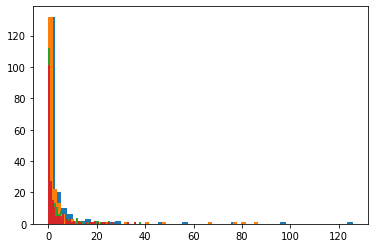

In [211]:
# get degree distribution for each graph
for key in df['keys']:
    # Load the graph from the dictionary using its key
    G = G_strong[key]
    weights = nx.get_edge_attributes(G, 'weight')
    
    # Create a histogram of the edge weights
    plt.hist(weights.values(), bins=50)
    

In [214]:
keys = list(graphs.keys())
df_surrogate = pd.DataFrame({'keys': keys, 'case': [c[0:-1] for c in keys], 'hemi': [c[-1] for c in keys]})
df_surrogate = df_surrogate.sort_values('keys')

#randomly permute edge weights
G_surrogate = dict()

for key in df_surrogate['keys']:
    G = G_strong[key]
    betweneess_trial = list()
    avg_shortest_path_trial = list()
    for trial in range(200):
        weights_shuffled = permute_edge_weights(G)
    
        # Create a new graph with the randomly permuted weights
        G_surr = nx.DiGraph()
        G_surr.add_edges_from((u, v, {'weight': w}) for (u, v), w in weights_shuffled.items())

        # Calculate the betweenness centrality of each node in the graph
        betweeness_centrality = nx.betweenness_centrality(G_surr, normalized=True, weight = lambda x,y,z: 1/z['weight'])
        avg_shortest_path = nx.average_shortest_path_length(G_surr, weight = lambda x,y,z: 1/z['weight'])
        
        betweneess_trial.append(np.mean(list(betweeness_centrality.values())))
        avg_shortest_path_trial.append(avg_shortest_path)

    # Add the results as a new row to the DataFrame
    df_surrogate.loc[df_surrogate['keys'] == key, 'avg_betweeness'] = np.median(betweneess_trial)
    df_surrogate.loc[df_surrogate['keys'] == key, 'std_betweeness'] = np.std(betweneess_trial)
    df_surrogate.loc[df_surrogate['keys'] == key, 'real_betweeness'] =  df.loc[df['keys'] == key, 'betweeness_weight']
    df_surrogate.loc[df_surrogate['keys'] == key, 'avg_avg_shortest_path'] = np.median(avg_shortest_path_trial)
    df_surrogate.loc[df_surrogate['keys'] == key, 'std_avg_shortest_path'] = np.std(avg_shortest_path_trial)
    df_surrogate.loc[df_surrogate['keys'] == key, 'real_avg_shortest_path'] =  df.loc[df['keys'] == key, 'avg_shortest_path_weight']
    

<Axes: xlabel='keys'>

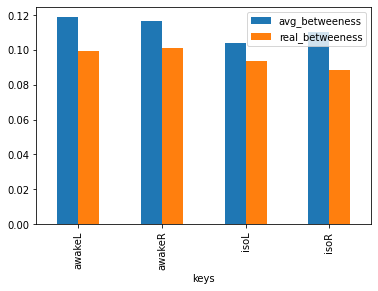

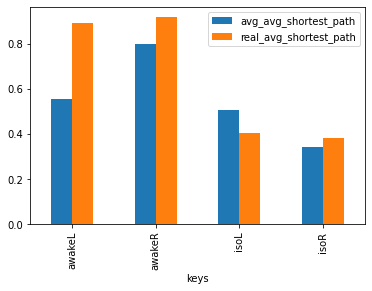

In [215]:
df_surrogate.plot.bar(x = 'keys', y=['avg_betweeness', 'real_betweeness'])
df_surrogate.plot.bar(x = 'keys', y=['avg_avg_shortest_path', 'real_avg_shortest_path'])